In [1]:
#Image Data prepared with https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d
import tensorflow as tf
print(tf.version.VERSION)

2.1.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
from matplotlib.pyplot import imread
import numpy as np

def make_array(path):
    filelist = glob.glob(path)
    x = np.array([np.array(imread(fname)) for fname in filelist])
    return x

train_num=len(glob.glob('./run_training/data/train_frames/train/*.tif'))
val_num=len(glob.glob('./run_training/data/val_frames/val/*.tif'))


In [3]:
images = make_array('./run_training/data/train_frames/train/*.tif')

In [4]:
images.shape

(416, 512, 512)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
from matplotlib.pyplot import imread
import numpy as np

def make_array(path):
    filelist = glob.glob(path)
    x = np.array([np.array(imread(fname)) for fname in filelist])
    return x

train_num=len(glob.glob('./run_training/data/train_frames/train/*.tif'))
val_num=len(glob.glob('./run_training/data/val_frames/val/*.tif'))

#1-channel images
images = make_array('./run_training/data/train_frames/train/*.tif').reshape(train_num,512,512,1)
masks = make_array('./run_training/data/train_masks/train/*.tif').reshape(train_num,512,512,1)
val_images = make_array('./run_training/data/val_frames/val/*.tif').reshape(val_num,512,512,1)
val_masks = make_array('./run_training/data/val_masks/val/*.tif').reshape(val_num,512,512,1)


#check px values
#test=val_images.reshape(8,512,512,1)
#test[0][150]
print("train_images: "+str(images.shape))
print("train_masks: "+str(masks.shape))
print("val_images: "+str(val_images.shape))
print("val_masks: "+str(val_masks.shape))

train_images: (416, 512, 512, 1)
train_masks: (416, 512, 512, 1)
val_images: (119, 512, 512, 1)
val_masks: (119, 512, 512, 1)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE=8

#img_gen_args = dict(rescale=1./65535)
#mask_gen_args = dict(rescale=1./65535)

data_gen_args = dict(rescale=1./65535,
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')


image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator(**data_gen_args)
val_mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow(
    images, y=None, shuffle=False, batch_size=BATCH_SIZE, sample_weight=None, seed=seed,
    save_to_dir=None, subset=None
)

mask_generator = image_datagen.flow(
    masks, y=None, shuffle=False, batch_size=BATCH_SIZE, sample_weight=None, seed=seed,
    save_to_dir=None, subset=None
)

val_image_generator = image_datagen.flow(
    val_images, y=None, shuffle=False, batch_size=BATCH_SIZE, sample_weight=None, seed=seed,
    save_to_dir=None, subset=None
)

val_mask_generator = image_datagen.flow(
    val_masks, y=None, shuffle=False, batch_size=BATCH_SIZE, sample_weight=None, seed=seed,
    save_to_dir=None, subset=None
)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

#val_mask_generator[0][0][150]
val_image_generator[0].shape

(8, 512, 512, 1)

In [4]:
#From https://github.com/zhixuhao/unet/blob/master/model.py

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet(pretrained_weights=None, input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model

In [5]:
m=unet()
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

NO_OF_TRAINING_IMAGES = len(os.listdir('./run_training/data/train_frames/train/'))
NO_OF_VAL_IMAGES = len(os.listdir('./run_training/data/val_frames/val/'))

NO_OF_EPOCHS = 20
BATCH_SIZE = 8 

TRAIN_STEPS = NO_OF_TRAINING_IMAGES//BATCH_SIZE
VAL_STEPS = NO_OF_VAL_IMAGES//BATCH_SIZE

In [7]:
import datetime

m=unet()

log_path = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

weights_path = './run_training/checkpoints'
checkpoint = ModelCheckpoint(weights_path, monitor='loss', mode='min',
                             verbose=1, save_best_only=True)

csv_logger = CSVLogger('./logs/log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor ='loss', mode='min', verbose = 1,
                              min_delta = 0.01, patience = 3)

callbacks_list = [tensorboard_callback, checkpoint, csv_logger, earlystopping]

In [8]:
#If using imports from tensorflow.keras.

results = m.fit(
    x=train_generator, batch_size=BATCH_SIZE, epochs=NO_OF_EPOCHS, verbose=1, 
    shuffle=True, class_weight=None, validation_data=val_generator, validation_steps=VAL_STEPS,
    sample_weight=None, initial_epoch=0, steps_per_epoch=TRAIN_STEPS,
    max_queue_size=10, workers=1, callbacks=callbacks_list,
    use_multiprocessing=False
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 14 steps
Epoch 1/20
51/52 [============================>.] - ETA: 3:10 - loss: 0.3892 - accuracy: 0.9359
Epoch 00001: loss improved from inf to 0.38328, saving model to ./run_training/checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./run_training/checkpoints/assets
52/52 [==============================] - 10409s 200s/step - loss: 0.3833 - accuracy: 0.9362 - val_loss: 0.2428 - val_accuracy: 0.9541
Epoch 2/20
51/52 [============================>.] - ETA: 2:11 - loss: 0.2083 - accuracy: 0.9516
Epoch 00002: loss improved from 0.38328 to 0.20677, saving model to ./run_training/checkpoints
INFO:tensorflow:Assets written to: ./run_training/checkpoints/assets
52/52 [==============================] - 7191s 138s/step - loss: 0.2068 - accuracy: 0.9516 - val_loss: 0.1582 - val_accuracy: 0.9535
Epoch 3/20
51/52 [==========================

In [156]:
#Load existing model from file
#Fill the path to your trained network

#9 Epochs, with data augmentation
path2network='./run_training/checkpoints/'

#One Epoch, no data augmentation
#path2network='../../Desktop/20200303/checkpoints/'

model = tf.keras.models.load_model(path2network)

In [157]:
results = model.predict(val_image_generator, verbose=1)

#Show classes instead of probabilities
pr_classes = results.argmax(axis=-1)
pr = list(pr_classes)

15/15 [==============================] - 408s 27s/step


In [158]:
results.shape
pr = results.reshape(119,512,512)
pr[0].shape

(512, 512)

Num Images in Prediction: 119
Dimensions of Predicted Images: (512, 512)
Showing Prediction for Image #8


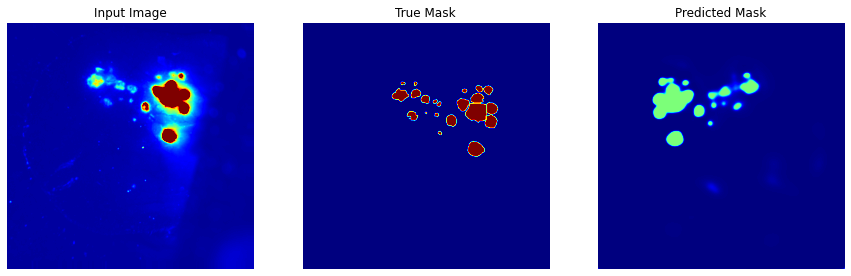

0.14554195

In [161]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print("Num Images in Prediction: "+str(len(pr)))
print("Dimensions of Predicted Images: "+str(pr[0].shape))

img_to_show=7

print("Showing Prediction for Image #"+str(img_to_show+1))

img=pr[img_to_show]

cmap=["jet","jet","jet"]
vmin=[0,0,0]
vmax=[.1,1,1]

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
    plt.axis('off')
  plt.show()

in_img = val_image_generator[0][img_to_show].reshape(512,512)
true_mask = val_mask_generator[0][img_to_show].reshape(512,512)
pr_mask = pr[img_to_show].reshape(512,512)

display_list=[in_img,true_mask,pr_mask]
display(display_list)

max(pr_mask[0])
#in_img[150:200]

In [167]:
#AUC and ROC

from sklearn.metrics import roc_curve, roc_auc_score

binaries_forROC = np.round((val_masks)/65565.).astype(int).reshape(119*512*512)
pr_forROC = pr.reshape(119*512*512)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(binaries_forROC, pr_forROC)

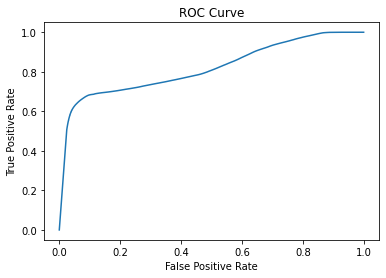

In [168]:
plt.plot(fpr, tpr)
_=plt.xlabel("False Positive Rate")
_=plt.ylabel("True Positive Rate")
#plt.plot(tpr, label = 'tpr')
#plt.plot(fpr, label = 'fpr')
_=plt.title("ROC Curve")

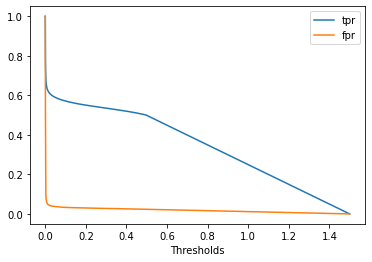

In [169]:
plt.plot(thresholds, tpr, label = 'tpr')
plt.plot(thresholds, fpr, label = 'fpr')
_=plt.xlabel("Thresholds")
_=plt.legend()

In [166]:
auc_score=roc_auc_score(binaries_forROC, pr_forROC)
print("AUC Score: "+str(auc_score))

AUC Score: 0.818167703483778
